<a href="https://colab.research.google.com/github/abysse8/F23-Wavelet-Project/blob/main/Modified_NN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Notebook
This notebook demonstrates the construction and training of a simple convolutional neural network (CNN),
specifically designed for image classification tasks. The network utilizes wavelet transforms and explores the impact of
varying sparsity levels on model performance. The code includes model definition, data loading, training, and visualization of results.

TO INSTALL

pip install torch torchvision torchaudio

pip install pywavelets

pip install tqdm

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pywt  # PyWavelets for wavelet transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from math import ceil  # Used in the SimpleCNN class

In [119]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

# Test CUDA operation
if torch.cuda.is_available():
    x = torch.tensor([1.0, 2.0])
    print("Original Device:", x.device)
    x = x.to("cuda")
    print("New Device:", x.device)
else:
    print("CUDA is not available.")


PyTorch Version: 2.1.0+cu118
CUDA Available: True
Original Device: cpu
New Device: cuda:0


In [120]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [121]:
def to_wavelet_coeffs(data, wavelet='db1', mode='symmetric'):
    coeffs = pywt.wavedec2(data, wavelet=wavelet, mode=mode, level=1)
    # Take only the first level decomposition
    cA, (cH, cV, cD) = coeffs
    # Stack coefficients in a single tensor (you can also experiment with other ways of combining these)
    coeffs_tensor = torch.stack([torch.Tensor(cA), torch.Tensor(cH), torch.Tensor(cV), torch.Tensor(cD)])
    return coeffs_tensor

# Custom Dataset class
class WaveletDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Convert image to numpy array and apply wavelet transform
        image_array = np.array(image)
        wavelet_coeffs = to_wavelet_coeffs(image_array)
        return wavelet_coeffs, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

dtd = torchvision.datasets.DTD(root='./data', download=True, transform=transform)

# Define a subset of the dataset
subset_indices = np.random.choice(len(dtd), 60, replace=False) # Adjust 1000 to the number of samples you want
dtd_train_subset = Subset(dtd, subset_indices)

# Create wavelet transformed datasets
wavelet_train_subset = WaveletDataset(dtd_train_subset)

# DataLoader for the subset
train_loader_subset = DataLoader(wavelet_train_subset, batch_size=20, shuffle=True)

In [122]:
y = next(iter(train_loader_subset))[0]
x, lab = next(iter(train_loader_subset))
print(y.shape, x.shape)

torch.Size([20, 4, 3, 128, 128]) torch.Size([20, 4, 3, 128, 128])


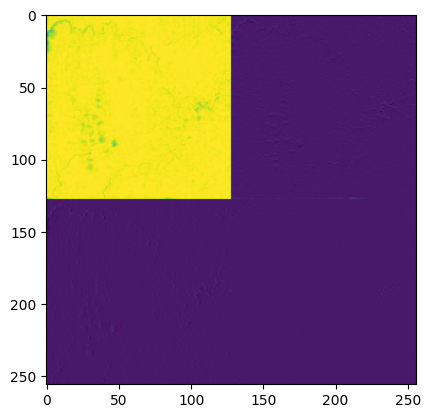

In [123]:
def wavelet_display(decomped):
    plt.imshow(torch.concat((torch.concat((decomped[0],decomped[1]), dim=-1), torch.concat((decomped[2],decomped[3]), dim=-1)), dim=-2))

wavelet_display(x[0,:,0])

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

class SimpleCNN(nn.Module):
    def __init__(self, mode='normal', num_kernels=32, num_classes=47, sparse=1):
        super(SimpleCNN, self).__init__()
        self.mode = mode
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, max(1, ceil(num_kernels*sparse)), kernel_size=3, stride=1, padding=1)
        self.conv1a = nn.Conv2d(3, max(1, ceil(num_kernels * sparse*0.5)), kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(3, max(1, ceil(num_kernels * sparse*0.5)), kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(max(1, ceil(num_kernels * sparse)), num_kernels, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Calculate flattened size dynamically
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_input = self.conv2(self.pool(F.relu(self.conv1(dummy_input))))
        dummy_input = dummy_input.view(1,-1)
        self.flattened_size = dummy_input.shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def separate_channels(self, x1, x2):
      # Apply convolution and ReLU to each input
      x1 = F.relu(self.conv1a(x1))
      x2 = F.relu(self.conv1b(x2))

      # Concatenate along the channel dimension
      x = torch.cat((x1, x2), dim=1)  # dim=1 for channel dimension
      # Pooling can be applied after concatenation
      return self.pool(x)

    def forward_phase1(self, x):
        if self.mode == 'normal':
            x = x[:, 0]  # Select the first channel and keep the dimension
            x = self.pool(F.relu(self.conv1(x)))  # Apply convolution and pooling
        elif self.mode == 'modified':
            x1 = x[:, 1]  # Select the second channel and keep the dimension
            x2 = x[:, 2]  # Select the third channel and keep the dimension
            x = self.separate_channels(x1, x2)
        return x

    def forward_phase2(self, x):
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, x):
        x = self.forward_phase1(x)
        x = self.forward_phase2(x)
        return x

def check_size():
    model_normal = SimpleCNN(mode='normal', num_kernels=32, sparse=0.5, num_classes=47)
    model_modified = SimpleCNN(mode='modified', num_kernels=32, sparse=0.5, num_classes=47)

    dummy_input = torch.randn(1, 4, 3, 128, 128)

    print("----------Phase 1----------")
    output_normal = model_normal.forward_phase1(dummy_input)
    output_modified = model_modified.forward_phase1(dummy_input)
    print(f"Unseparated channels:{output_normal.shape}")
    print(f"Separated channels:{output_modified.shape}")
    print("----------Phase 2----------")
    output_normal = model_normal.forward_phase2(output_normal)
    output_modified = model_modified.forward_phase2(output_modified)
    print(f"Unseparated channels:{output_normal.shape}")
    print(f"Separated channels:{output_modified.shape}")
    return output_normal.size() == output_modified.size()

# Example usage
sizes_match = check_size()
print("Do the sizes match after the first phase for both modes? ", sizes_match)

----------Phase 1----------
Unseparated channels:torch.Size([1, 16, 64, 64])
Separated channels:torch.Size([1, 16, 64, 64])
----------Phase 2----------
Unseparated channels:torch.Size([1, 47])
Separated channels:torch.Size([1, 47])
Do the sizes match after the first phase for both modes?  True


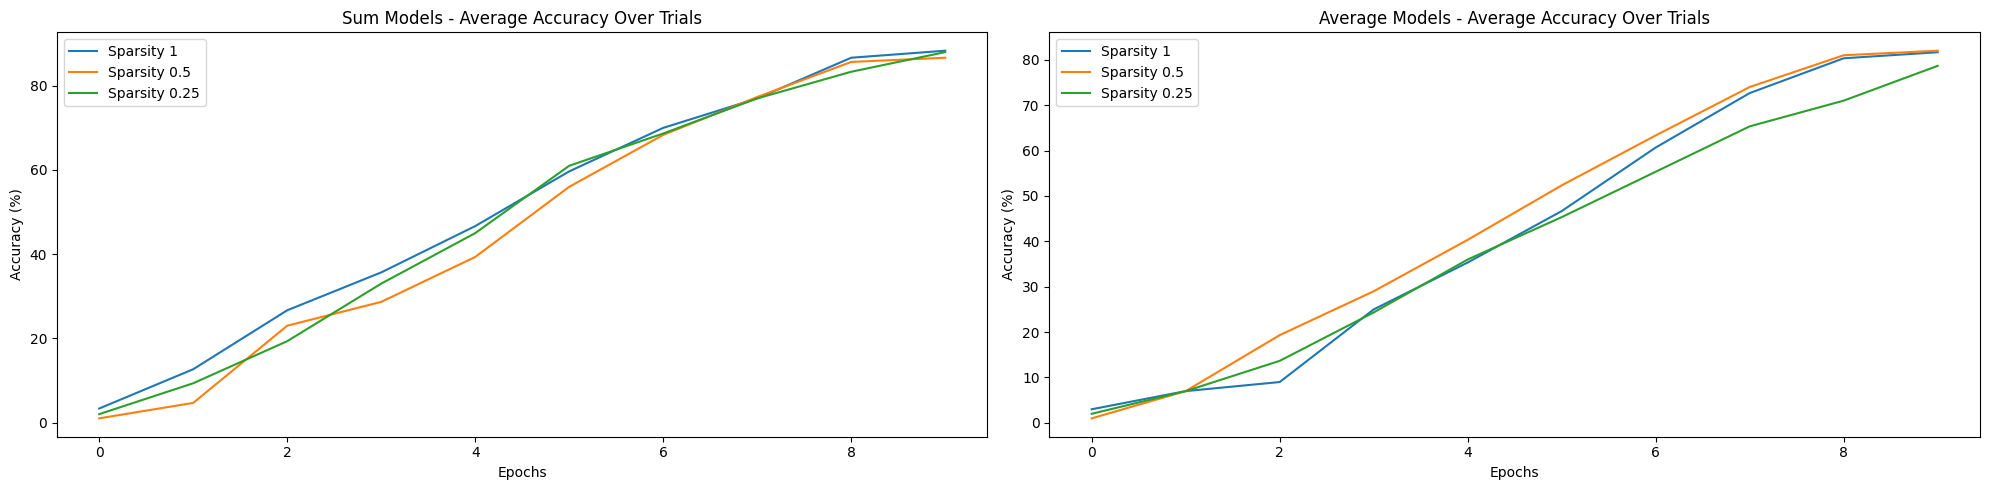

In [125]:
def train_model(model, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        total = 0
        correct = 0
        epoch_loss = 0.0
        for inputs, labels in train_loader_subset:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_history.append(epoch_loss / total)
        accuracy_history.append(100 * correct / total)

    return loss_history, accuracy_history

# Training loop
epochs = 10
num_trials = 5

fig, (ax_sum, ax_avg) = plt.subplots(1, 2, figsize=(20, 5))

for sparsity_index in [1, 0.5, 0.25]:
    all_accuracies_sum = []
    all_accuracies_avg = []

    for trial in range(num_trials):
        model_sum = SimpleCNN(mode='normal', sparse=sparsity_index).to(device)
        model_avg = SimpleCNN(mode='modified', sparse=sparsity_index).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_sum = torch.optim.Adam(model_sum.parameters(), lr=0.001)
        optimizer_avg = torch.optim.Adam(model_avg.parameters(), lr=0.001)

        _, accuracy_history_sum = train_model(model_sum, criterion, optimizer_sum, epochs=epochs)
        _, accuracy_history_avg = train_model(model_avg, criterion, optimizer_avg, epochs=epochs)

        all_accuracies_sum.append(accuracy_history_sum)
        all_accuracies_avg.append(accuracy_history_avg)

    avg_accuracy_history_sum = [sum(epoch_accuracies) / num_trials for epoch_accuracies in zip(*all_accuracies_sum)]
    avg_accuracy_history_avg = [sum(epoch_accuracies) / num_trials for epoch_accuracies in zip(*all_accuracies_avg)]

    ax_sum.plot(avg_accuracy_history_sum, label=f'Sparsity {sparsity_index}')
    ax_avg.plot(avg_accuracy_history_avg, label=f'Sparsity {sparsity_index}')

ax_sum.set_xlabel('Epochs')
ax_sum.set_ylabel('Accuracy (%)')
ax_sum.set_title('Sum Models - Average Accuracy Over Trials')
ax_sum.legend()

ax_avg.set_xlabel('Epochs')
ax_avg.set_ylabel('Accuracy (%)')
ax_avg.set_title('Average Models - Average Accuracy Over Trials')
ax_avg.legend()

plt.tight_layout()
plt.show()